# **Convolutional Neural Network (U-net)** Crevasse Finder

Here in this jupyter notebook, we will train a convolutional neural network, specifically a U-net with encoder and decoder blocks, to recognize crevasses from an input satellite image.

References:

- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
- [Deep Learning for Semantic Segmentation of Aerial Imagery](https://www.azavea.com/blog/2017/05/30/deep-learning-on-aerial-imagery/)

# Part 0 - Intro

In [1]:
# Set number of GPUs
num_gpus: int = 4   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set height (y-axis length) and width (x-axis length) which will be used to train model on later
img_height, img_width = (256,256)  #Default to (256,256), use (None,None) if you do not want to resize imgs

In [2]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
# Import all the necessary libraries
import os
import datetime
import glob
import random
import sys
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import pandas as pd
import rasterio
import skimage.io
import quilt

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose, SeparableConv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda, AlphaDropout, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import multi_gpu_model, plot_model
from keras import backend as K
import tensorflow as tf
import tensorflowjs as tfjs
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)
tf.test.gpu_device_name()

Using TensorFlow backend.


Python       : 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:39:56) 
Numpy        : 1.14.2
Scikit-learn : 0.19.1
Keras        : 2.1.5
Tensorflow   : 1.7.0


'/device:GPU:0'

In [4]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
tf.set_random_seed(seed=seed)

# Load Data from Quilt or npy file

In [5]:
# Have a look at our model folder
print(os.listdir('model'))  #see what's in the input folder (where data is in)
#os.getcwd()

['.ipynb_checkpoints', 'train', 'weights', 'logs', 'README.md', 'build.yml', 'intertrain']


In [6]:
quilt.install(package='weiji14/nz_space_challenge', hash='020fe3af', force=True)

100%|██████████| 352M/352M [00:00<00:00, 43.2GB/s]

In [7]:
from quilt.data.weiji14 import nz_space_challenge
X_data = np.load(nz_space_challenge.train.X_data())
Y_data = np.load(nz_space_challenge.train.Y_data())

In [8]:
#if os.path.exists('model/train/X_data.npy') and os.path.exists('model/train/Y_data.npy'):
#    X_data = np.load('model/train/X_data.npy')
#    Y_data = np.load('model/train/Y_data.npy')

In [9]:
X_data.shape, X_data.dtype, Y_data.shape, Y_data.dtype

((152, 256, 256, 3), dtype('uint8'), (152, 256, 256, 1), dtype('bool'))

In [10]:
X_data = (X_data/2**8).astype(dtype=np.float32)  #rescale uint8 X_data to float32 values between 0 and 1
#X_data = (X_data/2**16).astype(dtype=np.float32)  #rescale uint16 X_data to float32 values between 0 and 1

# Part 2 - Build model

In [11]:
# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.50, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(condition=tf.equal(y_true, 1), x=y_pred, y=tf.ones_like(y_pred))
        pt_0 = tf.where(condition=tf.equal(y_true, 0), x=y_pred, y=tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [12]:
# Design our model architecture here
def keras_model(img_height=256, img_width=256, img_channels=3, tensorboard_images=False):
    '''
    Modified from https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/
    Architecture inspired by https://blog.deepsense.ai/deep-learning-for-satellite-imagery-via-image-segmentation/
    '''
    encoder_exps = [5,6,7,8,9]   #the n-th deep channel's exponent i.e. 2**n 16,32,64,128,256
    decoder_exps = [8,7,6,5]   #reversed order of exponents e.g. 128,64,32,16
    k_size = (3, 3)                     #size of filter kernel
    k_init = 'lecun_normal'             #kernel initializer
    activation = 'selu'
    
    ## Standard layers we use a lot in the model
    dropout = lambda rate: Dropout(rate=rate)   #lambda rate: AlphaDropout(rate=rate)
    conv2d = lambda filters: SeparableConv2D(filters=filters, kernel_size=k_size,
                                              activation=activation, padding='same',
                                              depthwise_initializer=k_init, pointwise_initializer=k_init,
                                              use_bias=False)
    
    if K.image_data_format() == 'channels_first':
        ch_axis = 1
        input_shape = (img_channels, img_height, img_width)
    elif K.image_data_format() == 'channels_last':
        ch_axis = 3
        input_shape = (img_height, img_width, img_channels)

    inp = Input(shape=input_shape)
    if tensorboard_images == True:
        tf.summary.image(name='input', tensor=inp)
    
    # encoder
    enc_ = []
    enc = inp
    print(encoder_exps)
    for i, n_ch in enumerate(encoder_exps, start=1):  #loop from 1, 2, 3, ..., len(n_ch_exps)
        #with K.name_scope(f'Encode_block_{i}'):
            enc = BatchNormalization()(enc)
            enc = conv2d(filters=2**n_ch)(enc)
            enc = dropout(rate=0.2)(enc)
            enc = conv2d(filters=2**n_ch)(enc)
            enc_.append(enc)
            if i < len(encoder_exps):  #do not run max pooling on the last encoding/downsampling step
                enc = MaxPooling2D(pool_size=(2,2))(enc)  #strides = pool_size if strides is not set
                #enc[i] = Conv2D(filters=2**n_ch, kernel_size=k_size, strides=(2,2), activation=activation, padding='same', kernel_initializer=k_init)(enc[i])
    
    # decoder
    dec = enc
    print(decoder_exps)
    for j, n_ch in enumerate(decoder_exps, start=1):
        #with K.name_scope(f'Decode_block_{j}'):
            dec = Conv2DTranspose(filters=2**n_ch, kernel_size=k_size, strides=(2,2), activation=activation, padding='same', kernel_initializer=k_init)(dec)
            ## Bilinear upsampling + a Conv2D
            #new_width = int(img_width/(2**(len(decoder_exps)-j)))
            #new_height = int(img_height/(2**(len(decoder_exps)-j)))
            #print(new_width, new_height)
            #resize_function = lambda images: K.tf.image.resize_bilinear(images=images, size=[new_height,new_width], name=f'tf_bilinear_upsampling_{j}')
            #dec_.append(dec)
            #dec = Lambda(function=resize_function, name=f'bilinear_upsampling_{j}')(dec_[-1])
            #dec = conv2d(filters=2**n_ch)(dec)
            
            dec = Concatenate(axis=ch_axis)([dec, enc_[-(j+1)]])  #Use deepcopy?, see https://github.com/keras-team/keras/issues/5972
            dec = BatchNormalization()(dec)
            dec = conv2d(filters=2**n_ch)(dec)
            dec = dropout(rate=0.2)(dec)
            dec = conv2d(filters=2**n_ch)(dec)
            
    outp = SeparableConv2D(filters=1, kernel_size=k_size, activation='sigmoid', padding='same',
                           depthwise_initializer=k_init, pointwise_initializer=k_init, use_bias=False)(dec)
    if tensorboard_images == True:
        tf.summary.image(name='output', tensor=outp)
    
    model = Model(inputs=[inp], outputs=[outp])
    
    return model

In [13]:
# Set some model compile parameters
optimizer = keras.optimizers.Adam(lr=0.001)
loss      = [focal_loss(alpha=.5, gamma=7)] #jaccard_distance  #'binary_crossentropy'  #dice_coef_loss #bce_dice_loss
metrics   = [mean_iou]

# Compile our model
model = keras_model(img_width=img_width, img_height=img_height, img_channels=X_data.shape[-1], tensorboard_images=True)
model.summary()

# For more GPUs
if num_gpus > 1:
    model = multi_gpu_model(model, gpus=num_gpus)
    
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

[5, 6, 7, 8, 9]
[8, 7, 6, 5]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 256, 256, 32) 123         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 32) 0           separable_conv2d_1[0][0]         
________________________________________________________________________________

# Part 3 - Run model

In [14]:
# Runtime data augmentation
def get_train_test_augmented(X_data=X_data, Y_data=Y_data, validation_split=0.25, batch_size=32, seed=seed):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
    # Image data generator distortion options
    data_gen_args = dict(#rotation_range=5,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         #shear_range=0.2,
                         #zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')  #use 'constant'??


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator

In [15]:
# Runtime custom callbacks
#%% https://github.com/deepsense-ai/intel-ai-webinar-neural-networks/blob/master/live_loss_plot.py
# Fixed code to enable non-flat loss plots on keras model.fit_generator()
from keras.callbacks import Callback
from IPython.display import clear_output
#from matplotlib.ticker import FormatStrFormatter

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Log-loss (cost function)"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):
        #print(self.params['metrics'])
        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)
            
            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center left')
        
        plt.tight_layout()
        plt.show();

plot_losses = PlotLosses(figsize=(16, 4))

# Tensorboard
histogram_freq = 1  #Set to 0 when augmenting data, 1 when not using data augmentation
tensorboard = keras.callbacks.TensorBoard(log_dir='model/logs', histogram_freq=histogram_freq, write_graph=True, write_images=True)

# Model Checkpoints
os.makedirs(name="model/weights/checkpoints", exist_ok=True)
monitor = 'val_'+metrics[0].__name__  #what to monitor, either loss or metric
filepath="model/weights/checkpoints/weights-{0}-{1}.hdf5".format('{epoch:02d}', '{'+monitor+':.2f}')
checkpoint = ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=1, save_best_only=False, save_weights_only=True, mode='max')

# F1 related metrics
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        #print(self.params)
        self.params['metrics'].extend(['f1', 'val_f1', 'recall', 'val_recall', 'precision', 'val_precision'])
 
    def on_epoch_end(self, epoch, logs={}):
        #print(logs)
        #print(self.validation_data[0].shape, self.validation_data[1].shape)
        val_predict = np.round(np.asarray(self.model.predict(self.validation_data[0]))).ravel()
        val_targ = self.validation_data[1].ravel()
        
        assert(val_predict.shape == val_targ.shape)
        try:
            assert(sklearn.utils.multiclass.type_of_target(val_predict) == sklearn.utils.multiclass.type_of_target(val_targ))
        except AssertionError:
            print(sklearn.utils.multiclass.type_of_target(val_predict))
            #print(val_predict)
            print(sklearn.utils.multiclass.type_of_target(val_targ))
            #print(val_targ)
            
            #raise
            return
        
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        
        print("— val_f1: %f — val_precision: %f — val_recall %f" % (_val_f1, _val_precision, _val_recall))
        
        logs['f1'] = _val_f1
        logs['val_f1'] = _val_f1
        logs['recall'] = _val_recall
        logs['val_recall'] = _val_recall
        logs['precision'] = _val_precision
        logs['val_precision'] = _val_precision
        
        return

f1_metrics = Metrics()  #note that this f1_metrics needs to be placed as the first item in callbackList!

# Bring all the callbacks together into a python list
callbackList = [f1_metrics, plot_losses, tensorboard, checkpoint]
#callbackList = [plot_losses, tensorboard, checkpoint]

In [16]:
validation_split = 0.025
X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                    Y_data,
                                                    train_size=1-validation_split,
                                                    test_size=validation_split,
                                                    random_state=seed)
print("X_train: {0} tiles, X_test: {1} tiles".format(len(X_train), len(X_test)))

X_train: 148 tiles, X_test: 4 tiles


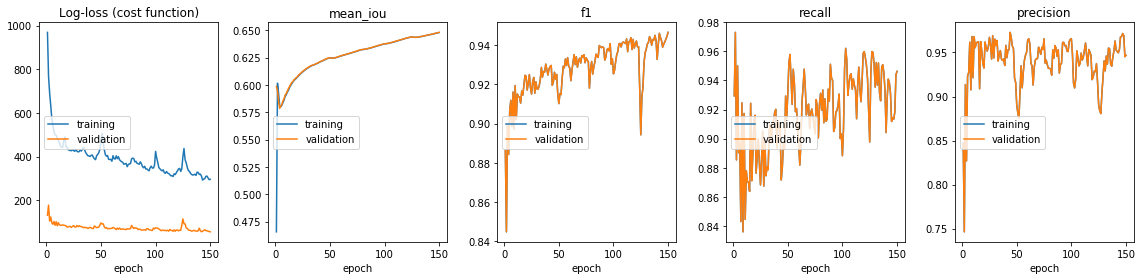


Epoch 00300: saving model to model/weights/checkpoints/weights-300-0.65.hdf5


In [17]:
# Finally train the model!!
batch_size = 32
epochs = 300

try:  #to load a checkpoint file if it exists
    weightDict = {int(os.path.split(filename)[-1][8:-10]): filename for filename in glob.glob("model/weights/checkpoints/weights-*-*.hdf5")}  #natural sort weight files
    initial_epoch = max(weightDict) if max(weightDict) <= epochs else epochs  #load the weights <= no. of epochs
    checkfile = weightDict[initial_epoch]  #retrieve the model weights from the hdf5 file
    model.load_weights(checkfile)
    print("Model weights loaded, resuming from epoch {0}".format(initial_epoch))
except (IndexError, ValueError):
    initial_epoch = 0
    try:
        model.load_weights("model/weights/crevasse-model-weights.hdf5")
        print("Model weights loaded, starting from epoch {0}".format(initial_epoch))
    except OSError:
        pass

model.fit(x=X_train, y=Y_train, verbose=1, validation_data=(X_test, Y_test),
          batch_size=batch_size, epochs=epochs,
          callbacks=callbackList, initial_epoch=initial_epoch)


#train_generator, test_generator = get_train_test_augmented(X_data=X_data, Y_data=Y_data,
#                                                           validation_split=validation_split, batch_size=batch_size)
#model.fit_generator(train_generator, validation_data=test_generator, validation_steps=batch_size/2,
#                    steps_per_epoch=len(X_train)/(batch_size*2), epochs=epochs,
#                    callbacks=callbackList, initial_epoch=max(initial_epoch, epochs-augmentation_epochs))

In [18]:
# Save the model weights to a hdf5 file
if num_gpus > 1:
    #Refer to https://stackoverflow.com/questions/41342098/keras-load-checkpoint-weights-hdf5-generated-by-multiple-gpus
    #model.summary()
    model.save_weights(filepath="model/weights/crevasse-model-weights-{0}-multi-gpu.hdf5".format(epochs))
    model_out = model.layers[-2]  #get second last layer in multi_gpu_model i.e. model.get_layer('model_1')
else:
    model_out = model

model_out.save_weights(filepath="model/weights/crevasse-model-weights.hdf5")

### Save model to tensorflowjs!!

In [19]:
tfjs.converters.save_keras_model(model=model_out, artifacts_dir='tfjs/')

# Part 4 - Evaluate output

In [20]:
# Reload the model
model_loaded = keras_model(img_width=img_width, img_height=img_height, img_channels=X_data.shape[-1])
model_loaded.load_weights("model/weights/crevasse-model-weights.hdf5")
model_loaded.compile(optimizer=optimizer, loss=loss, metrics=metrics)

[5, 6, 7, 8, 9]
[8, 7, 6, 5]


## Visualize predictions on the cross-validation test data

In [21]:
# Use model to predict test labels
Y_hat_test = model_loaded.predict(X_test, verbose=1)
print(Y_hat_test.shape, Y_hat_test.dtype)

4/4 [==============================] - 1s 305ms/step
(4, 256, 256, 1) float32


1 (256, 256, 3)


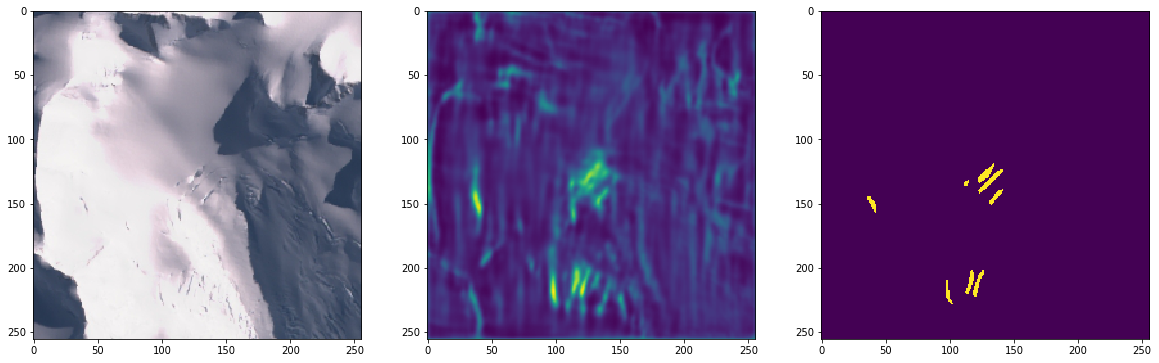

1 (256, 256, 3)


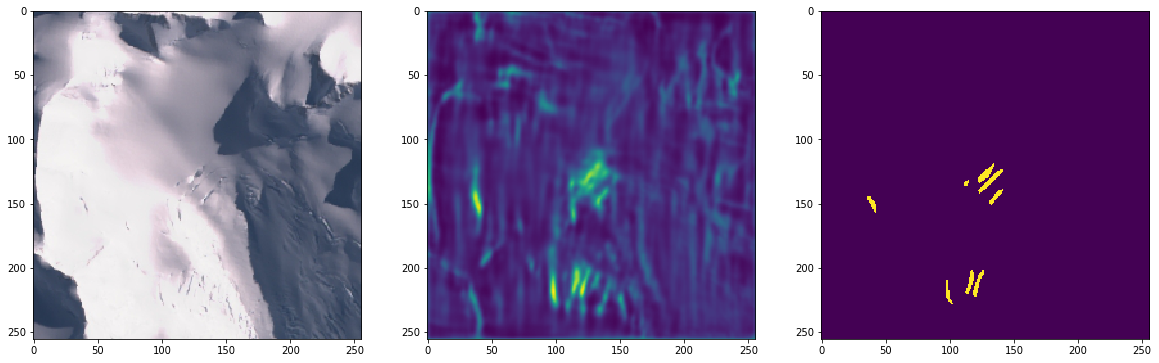

2 (256, 256, 3)


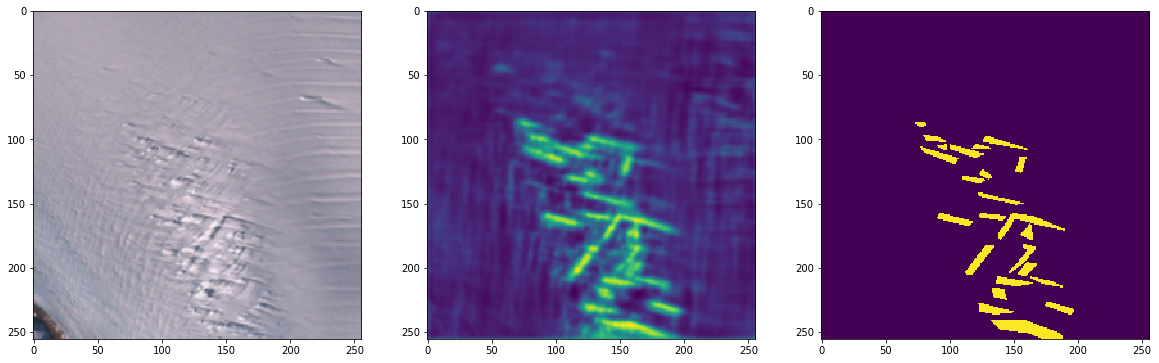

2 (256, 256, 3)


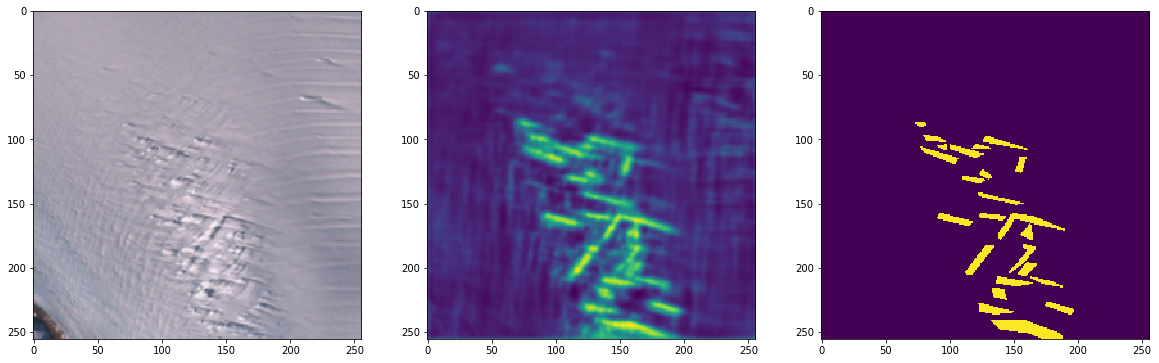

1 (256, 256, 3)


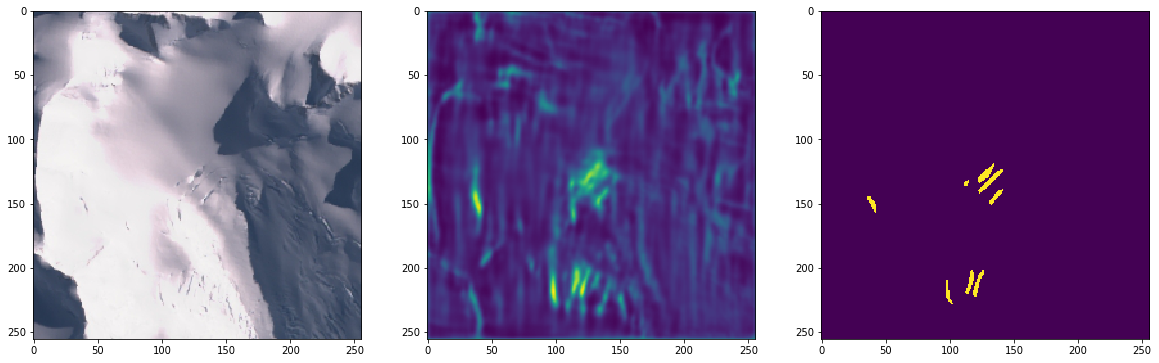

In [22]:
for i in range(5):
    try:
        id = random.randrange(0,len(Y_hat_test))
        print(id, X_test[id].shape)
        fig, axarr = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(20,20))
        axarr[0, 0].imshow(X_test[id])
        axarr[0, 1].imshow(Y_hat_test[id][:,:,0])
        axarr[0, 2].imshow(Y_test[id][:,:,0])
        plt.show()
    except TypeError:
        pass

## Visualize predictions on the training data

In [23]:
Y_hat_train = model_loaded.predict(X_train, verbose=1)
print(Y_hat_train.shape, Y_hat_train.dtype)

148/148 [==============================] - 5s 37ms/step
(148, 256, 256, 1) float32


106 (256, 256, 3)


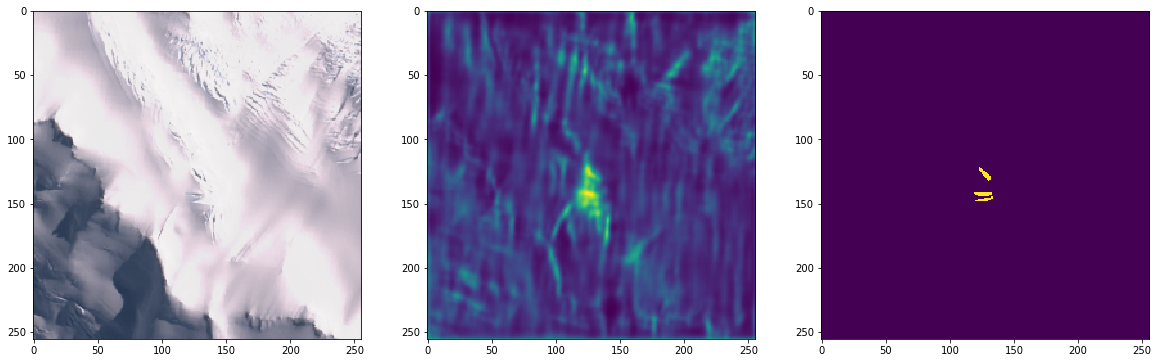

105 (256, 256, 3)


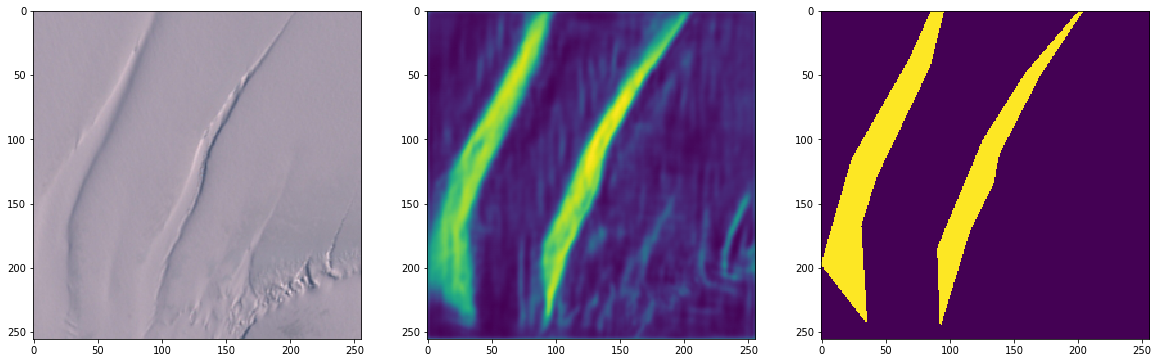

22 (256, 256, 3)


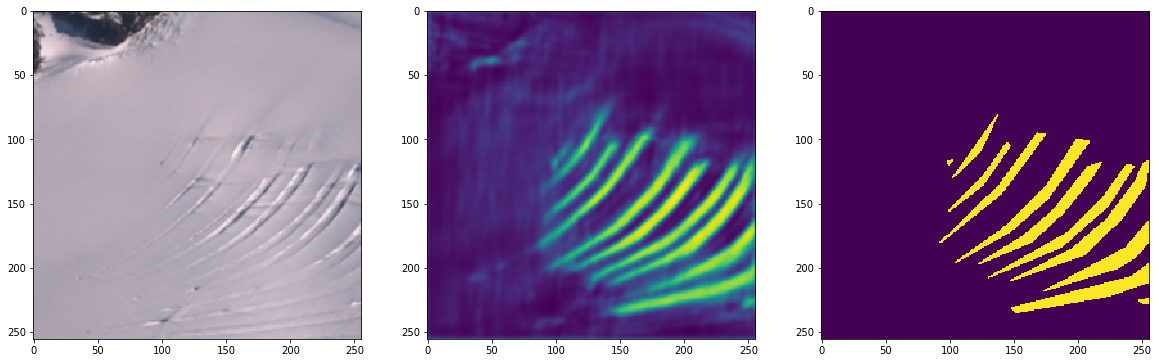

46 (256, 256, 3)


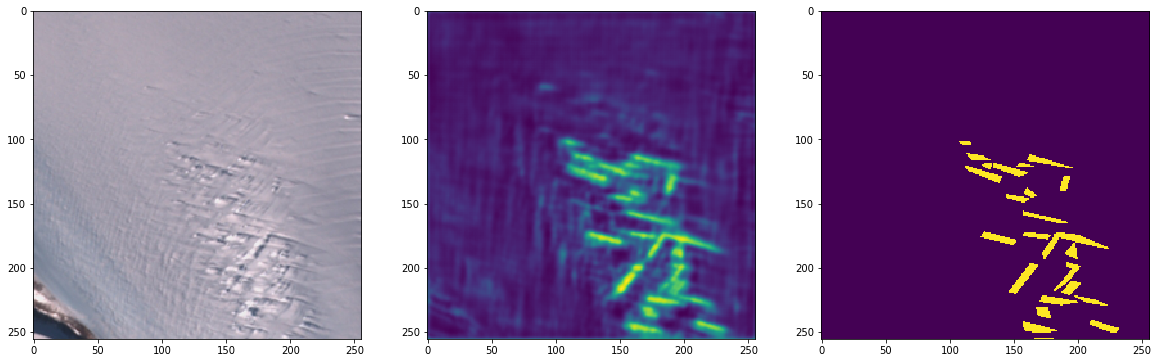

139 (256, 256, 3)


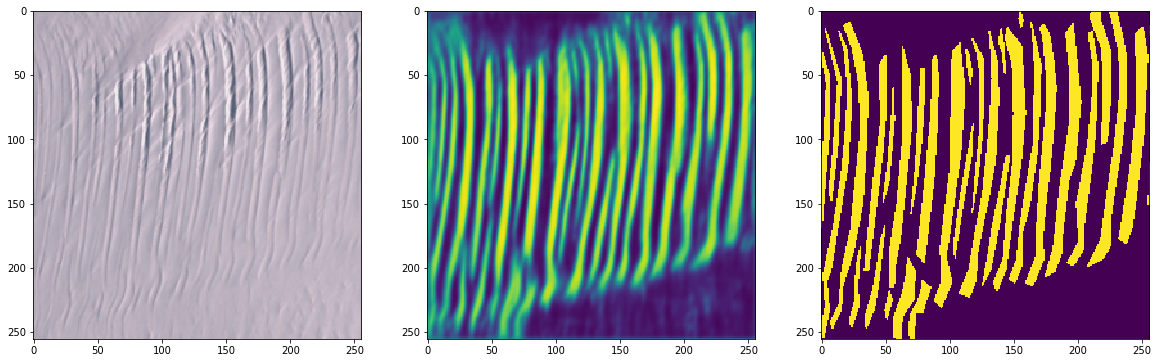

In [24]:
for i in range(5):
    try:
        id = random.randrange(0,len(Y_hat_train))
        print(id, X_train[id].shape)
        fig, axarr = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(20,20))
        axarr[0, 0].imshow(X_train[id], aspect='equal')
        axarr[0, 1].imshow(Y_hat_train[id][:,:,0], aspect='equal')
        axarr[0, 2].imshow(Y_train[id][:,:,0], aspect='equal')
        plt.show()
    except TypeError:
        pass

In [25]:
raise ValueError('temp')

ValueError: temp

# Part 5 - Predict on new area (Ross Ice Shelf) and save results

Use tiling and stitching back scheme from https://medium.com/the-downlinq/broad-area-satellite-imagery-semantic-segmentation-basiss-4a7ea2c8466f

In [ ]:
def ary_to_overlapping_tiles(ary:np.array, shape:tuple=(256,256), overlap:tuple=(32,32), show=False):
    """
    Function to turn a big 2D numpy array (image) and tile it into a lot of image chips
    of a standardized size. Chips will partially overlap each other.
    
    I.e. input shape (height, width, channels) --> output shape (m, height, width, channels)
    
    Outputs a stacked numpy array suitable for input into a Convolutional Neural Network
    """
    assert(isinstance(ary, np.ndarray))
    assert(isinstance(shape, tuple))
    assert(isinstance(overlap, tuple))
    
    print(f'Input image has shape {ary.shape}')
    ary_height, ary_width = shape
    stride_height, stride_width = overlap
    
    ary_list = []    
    
    total = 0
    excluded = 0
    if show == True:
        fig,ax = plt.subplots(nrows=1, figsize=(14.4,9.6))
        ax.imshow(X=ary[:,:,0])  #show first band of array only
    
    for x_step in range(0, ary.shape[1]-stride_width, ary_width-stride_width):
        for y_step in range(0, ary.shape[0]-stride_height, ary_height-stride_height):
            x0, x1 = x_step, x_step+ary_width
            y0, y1 = y_step, y_step+ary_height
            
            crop_ary = ary[y0:y1, x0:x1]
            try:
                total += 1
                assert(crop_ary.shape == (ary_height, ary_width, ary.shape[2]))  #do not include images not matching the intended size
                if show == True:
                    patch = matplotlib.patches.Rectangle(xy=(x0,y0), width=ary_width, height=ary_height, linewidth=0.5, edgecolor='r', fill=None)
                    ax.add_patch(p=patch)
            except AssertionError:
                excluded += 1
                print(y0,y1,x0,x1, crop_ary.shape, 'excluded')
                continue
            ary_list.append(crop_ary)
    
    if excluded > 0:
        print("INFO: {0}/{1} tiles were excluded due to not fitting shape {2}".format(excluded, total, shape))
    if show == True:
        plt.show()
            
    return np.stack(ary_list), excluded

In [ ]:
def overlapping_tiles_to_ary(stacked_ary:np.array, final_shape=(3616, 7200), overlap:tuple=(32,32)):  #final shape uses common multiples of "256 & 224" + stride "32"
    """
    Function to turn stacked overlapping 2D numpy arrays of shape (tiles, height, width, channels)
    into a single 2D numpy array (image) of shape (height, width, channels)
    
    Outputs a single numpy array suitable for converting into a raster such as a Geotiff
    """
    
    assert(len(stacked_ary.shape) == 4)
    
    ary_height = stacked_ary.shape[1]
    ary_width = stacked_ary.shape[2]
    stride_height, stride_width = overlap
    
    output_ary = np.zeros(shape=final_shape+(stacked_ary.shape[3],))
    coverage_map = output_ary.copy()
    
    index = 0
    for x_step in range(0, final_shape[1]-stride_width, ary_width-stride_width):
        for y_step in range(0, final_shape[0]-stride_height, ary_height-stride_height):
            x0, x1 = x_step, x_step+ary_width
            y0, y1 = y_step, y_step+ary_height
            
            output_ary[y0:y1,x0:x1] += stacked_ary[index]
            coverage_map[y0:y1,x0:x1] += np.ones_like(a=stacked_ary[index])
            
            index += 1
    
    output_ary /= coverage_map  #normalize the output array using overlap coverage map
    
    return output_ary

In [ ]:
display = True
#if not os.path.exists('model/intertrain/crevasse_map.tif'):
if 1==1:
    with rasterio.open(fp='data/nsidc-0280/moa125_2004_hp1_v1.1.tif') as raster_source:
        # Create numpy array of input raster
        Z_data = raster_source.read(indexes=list(range(1,raster_source.count+1)), masked=True)  #outputs a masked numpy array of shape (1, height, width)
        Z_data = np.rollaxis(a=Z_data, axis=0, start=3)
        
        xmin, ymin, xmax, ymax = (20000, 25000, 27200, 28616)  #image coordinates where y values increase going down
        Z_data = Z_data[ymin:ymax, xmin:xmax,:]  #crop of Ross Ice Shelf
        Z_data = (Z_data/2**16).astype(newtype=np.float32)  #rescale uint16 Z_data to float32 values between 0 and 1
        
        west, north = rasterio.transform.xy(transform=raster_source.transform, cols=xmin, rows=ymin)  #geographic coordinates
        east, south = rasterio.transform.xy(transform=raster_source.transform, cols=xmax, rows=ymax)  #geographic coordinates
    
    Z_test, excluded = ary_to_overlapping_tiles(ary=Z_data, shape=(256,256), overlap=(32,32), show=True)
    Z_hat_test = model_loaded.predict(Z_test, verbose=1)
    print('Finished predict on {0} tiles of shape ({1},{2})'.format(*Z_hat_test.shape))
    
    Z_hat = overlapping_tiles_to_ary(stacked_ary=Z_hat_test, final_shape=Z_data.shape[:2])
    print(Z_hat.shape)
    
    if display == True:
        fig, axarr = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(14.4,9.6))
        axarr[0, 0].imshow(Z_hat[:,:,0])

In [ ]:
## Save seamless crevasse map (Z_hat) and the actual input earth observation seamless image (Z_data) to geotiff
os.makedirs(name='model/intertrain', exist_ok=True)
transform = rasterio.transform.from_bounds(west=west, south=south, east=east, north=north, width=xmax-xmin, height=ymax-ymin)

crevasse_output = 'model/intertrain/crevasse_map.tif'
with rasterio.open(fp=crevasse_output, mode='w', driver='GTiff', height=Z_hat.shape[0],
                    width=Z_hat.shape[1], count=1, dtype=Z_hat.dtype,
                    crs=raster_source.crs, transform=transform) as crevasse_dataset:
    crevasse_dataset.write(Z_hat[:,:,0], 1)
    
earthobservation_output = 'model/intertrain/earthobservation_map.tif'
with rasterio.open(fp=earthobservation_output, mode='w', driver='GTiff', height=Z_data.shape[0],
                    width=Z_data.shape[1], count=1, dtype=Z_data.dtype,
                   crs=raster_source.crs, transform=transform) as earthobservation_dataset:
    earthobservation_dataset.write(Z_data[:,:,0], 1)
print(f'New geotifs exported to {crevasse_output} and {earthobservation_output}')

# Save to [quilt](https://quiltdata.com/)

This will make it a bit easier for anyone to reproduce the output data from this notebook without going through all the steps above :P

In [ ]:
import quilt

In [ ]:
if os.path.exists('model/build.yml'):
    os.remove('model/build.yml')
quilt.generate(directory="model")

In [ ]:
quilt.login()

In [ ]:
quilt.build(package='weiji14/nz_space_challenge', path='model/build.yml')

In [ ]:
quilt.push(package='weiji14/nz_space_challenge', is_public=True)